<a href="https://colab.research.google.com/github/SahilSuvarna1023/Airline-Delay-Forecasting-System/blob/main/01_load_and_explore_parquet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
# Install DuckDB for SQL, and other tools
!pip install -q duckdb scikit-learn matplotlib seaborn pandas


In [33]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load and Register Data

In [34]:

import pandas as pd
import duckdb

file_path = "/content/drive/MyDrive/Flight_Delay_Data/flight_data.parquet"

df = pd.read_parquet(file_path)
print("✅ Data Loaded:", df.shape)

# Register with DuckDB for SQL querying
con = duckdb.connect()
con.register("flight_data", df)

✅ Data Loaded: (582425, 120)


# PHASE 1: SQL Exploration with DuckDB

 1.1: View Schema + Sample Rows

In [35]:
# Show schema
con.execute("PRAGMA table_info('flight_data')").df()

# Preview rows
con.execute("SELECT * FROM flight_data LIMIT 5").df()


,Year,Quarter,Month,DayofMonth,DayOfWeek,FlightDate,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,...,Div5Airport,Div5AirportID,Div5AirportSeqID,Div5WheelsOn,Div5TotalGTime,Div5LongestGTime,Div5WheelsOff,Div5TailNum,Duplicate,Unnamed: 119
0,2024,1,1,14,7,2024-01-14,UA,UA_CODESHARE,19977,UA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
1,2024,1,1,14,7,2024-01-14,UA,UA_CODESHARE,19977,UA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
2,2024,1,1,14,7,2024-01-14,UA,UA_CODESHARE,19977,UA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
3,2024,1,1,14,7,2024-01-14,UA,UA_CODESHARE,19977,UA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN
4,2024,1,1,14,7,2024-01-14,UA,UA_CODESHARE,19977,UA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN


 Flights by Delay Category (Check class balance)

In [36]:
con.execute("""
SELECT
  COUNT(*) AS total_flights,
  SUM(CASE WHEN DepDelay <= 0 THEN 1 ELSE 0 END) AS on_time,
  SUM(CASE WHEN DepDelay > 0 AND DepDelay <= 15 THEN 1 ELSE 0 END) AS minor_delay,
  SUM(CASE WHEN DepDelay > 15 THEN 1 ELSE 0 END) AS major_delay
FROM flight_data
""").df()


,total_flights,on_time,minor_delay,major_delay
0,582425,337757.0,97290.0,125908.0


Average Delay by Airline

In [37]:
con.execute("""
SELECT
  Marketing_Airline_Network AS airline,
  COUNT(*) AS flights,
  ROUND(AVG(DepDelay), 2) AS avg_dep_delay
FROM flight_data
GROUP BY airline
ORDER BY avg_dep_delay DESC
""").df()


,airline,flights,avg_dep_delay
0,AA,147443,19.63
1,B6,19580,19.15
2,F9,14379,18.85
3,UA,104791,16.92
4,G4,8596,15.41
5,NK,20415,15.05
6,DL,116199,14.52
7,AS,29057,13.58
8,WN,115389,12.14
9,HA,6576,9.96


Delay by Origin Airport (Top 10)

In [38]:
con.execute("""
SELECT
  Origin AS airport,
  COUNT(*) AS flights,
  ROUND(AVG(DepDelay), 2) AS avg_dep_delay
FROM flight_data
GROUP BY airport
ORDER BY avg_dep_delay DESC
LIMIT 10
""").df()


,airport,flights,avg_dep_delay
0,ELM,76,79.96
1,CKB,15,78.67
2,ALO,58,70.84
3,STC,18,67.22
4,SMX,9,63.33
5,CIU,61,57.82
6,SPI,72,55.62
7,ART,53,54.17
8,IMT,61,52.67
9,CID,633,52.46


Delay Trends by Month

In [39]:
con.execute("""
SELECT
  strftime('%Y-%m', CAST(FlightDate AS DATE)) AS year_month,
  COUNT(*) AS flights,
  ROUND(AVG(DepDelay), 2) AS avg_dep_delay
FROM flight_data
GROUP BY year_month
ORDER BY year_month
""").df()


,year_month,flights,avg_dep_delay
0,2024-01,582425,15.97


Export SQL Results

In [40]:
delay_by_airline = con.execute("SELECT Marketing_Airline_Network, ROUND(AVG(DepDelay), 2) AS avg_delay FROM flight_data GROUP BY Marketing_Airline_Network").df()
delay_by_airline.to_csv("/content/drive/MyDrive/Flight_Delay_Data/outputs/delay_by_airline.csv", index=False)


# Feature Engineering for ML

Load and Filter Valid Rows

In [41]:
# Only keep rows with valid DepDelay
df_ml = df[df['DepDelay'].notnull()].copy()


 Create Target Column – delay_category

In [42]:
def classify_delay(x):
    if x <= 0:
        return "on_time"
    elif x <= 15:
        return "minor_delay"
    else:
        return "major_delay"

df_ml["delay_category"] = df_ml["DepDelay"].apply(classify_delay)


Extract Useful Features

In [43]:
# Extract scheduled departure hour from CRSDepTime
df_ml["ScheduledHour"] = pd.to_datetime(df_ml["CRSDepTime"], format='%H%M', errors='coerce').dt.hour.fillna(0).astype(int)

# Build feature set
features = [
    "Marketing_Airline_Network",
    "Origin",
    "Dest",
    "Month",
    "DayOfWeek",
    "ScheduledHour",
    "Distance"
]

X = df_ml[features]
y = df_ml["delay_category"]


Encode Categorical Features

In [44]:
X_encoded = pd.get_dummies(X, drop_first=True)


Train-Test Split

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)


# PHASE 3.1: Train and Evaluate Random Forest Classifier (Multiclass)

Train the Random Forest Classifier

In [46]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)


In [ ]:
rf_model.fit(X_train, y_train)


Make Predictions

In [ ]:
y_pred = rf_model.predict(X_test)


 Evaluate the Model

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


In [31]:
import joblib

joblib.dump(rf_model, "/content/drive/MyDrive/Flight_Delay_Data/outputs/rf_multiclass_model.pkl")

# rf_binary_loaded = joblib.load("/content/drive/MyDrive/flight-delay/output/rf_multiclass_model.pkl")


['/content/drive/MyDrive/Flight_Delay_Data/outputs/rf_multiclass_model.pkl']

# PHASE 4: Visualize Model Results

 Confusion Matrix Heatmap

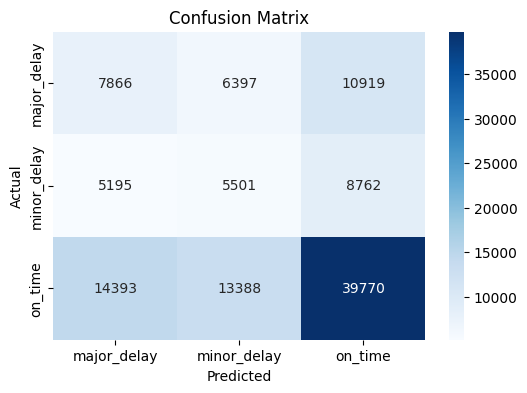

In [20]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_model.classes_,
            yticklabels=rf_model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Feature Importance Plot

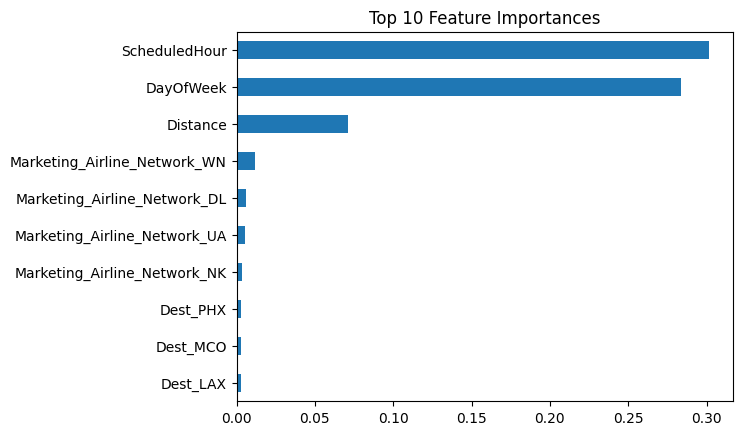

In [21]:
import pandas as pd

# Feature importances
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)

# Plot top 10
importances.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.gca().invert_yaxis()
plt.show()


Delay Category Distribution (Ground Truth vs. Predictions)

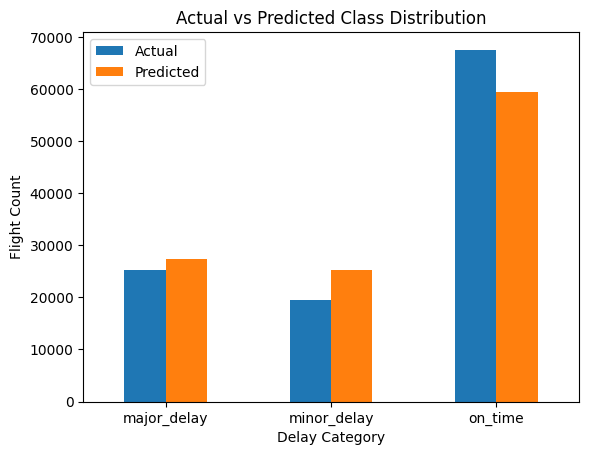

In [22]:
# True vs predicted class counts
actual_counts = y_test.value_counts().sort_index()
pred_counts = pd.Series(y_pred).value_counts().sort_index()

# Combine into one plot
pd.DataFrame({
    'Actual': actual_counts,
    'Predicted': pred_counts
}).plot(kind='bar')
plt.title("Actual vs Predicted Class Distribution")
plt.xlabel("Delay Category")
plt.ylabel("Flight Count")
plt.xticks(rotation=0)
plt.show()


# Phase 3.2 Binary Classification – Delayed vs Not Delayed

In [23]:
# Delay = True if DepDelay > 0
df_binary = df_ml.copy()
df_binary["is_delayed"] = df_binary["DepDelay"] > 0


In [24]:
X_bin = df_binary[features]
y_bin = df_binary["is_delayed"]

# One-hot encode
X_bin_encoded = pd.get_dummies(X_bin, drop_first=True)

# Train/test split
from sklearn.model_selection import train_test_split
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_bin_encoded, y_bin, test_size=0.2, random_state=42, stratify=y_bin
)


Train the Binary Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf_binary = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_binary.fit(X_train_bin, y_train_bin)


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

Evaluate

In [26]:
from sklearn.metrics import classification_report

y_pred_bin = rf_binary.predict(X_test_bin)
print(classification_report(y_test_bin, y_pred_bin))


              precision    recall  f1-score   support

       False       0.67      0.64      0.65     67551
        True       0.49      0.52      0.50     44640

    accuracy                           0.59    112191
   macro avg       0.58      0.58      0.58    112191
weighted avg       0.59      0.59      0.59    112191



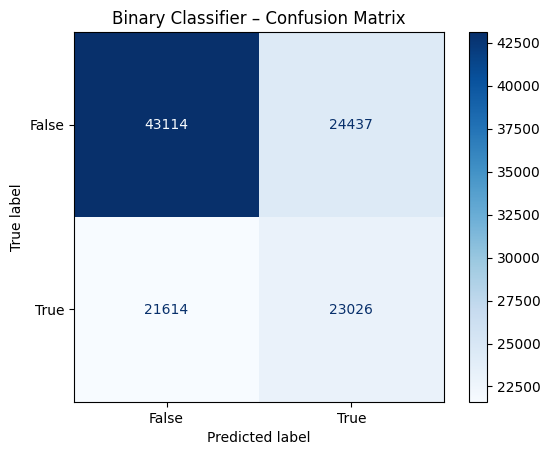

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_bin, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_binary.classes_)
disp.plot(cmap="Blues")
plt.title("Binary Classifier – Confusion Matrix")
plt.show()


ROC Curve

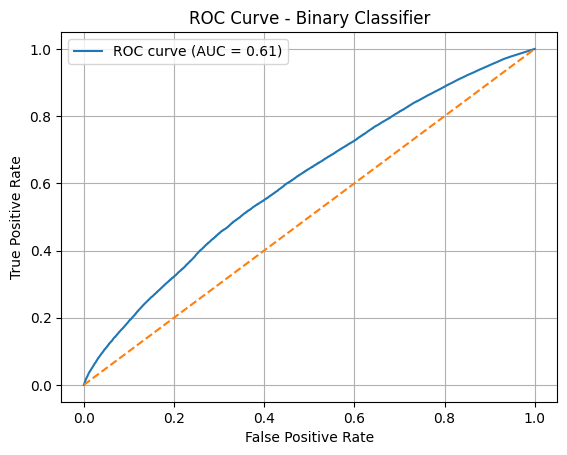

In [28]:
from sklearn.metrics import roc_curve, auc

y_prob = rf_binary.predict_proba(X_test_bin)[:, 1]
fpr, tpr, _ = roc_curve(y_test_bin, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc(fpr, tpr):.2f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Binary Classifier")
plt.legend()
plt.grid()
plt.show()


# PHASE 5: Save, Export, and Wrap-Up

In [29]:
import joblib

joblib.dump(rf_binary, "/content/drive/MyDrive/Flight_Delay_Data/outputs/rf_binary_model.pkl")

# rf_binary_loaded = joblib.load("/content/drive/MyDrive/flight-delay/output/rf_binary_model.pkl")


['/content/drive/MyDrive/Flight_Delay_Data/outputs/rf_binary_model.pkl']

In [30]:
pred_df = X_test_bin.copy()
pred_df["actual"] = y_test_bin.values
pred_df["predicted"] = y_pred_bin
pred_df.to_csv("/content/drive/MyDrive/Flight_Delay_Data/outputs/final_predictions.csv", index=False)
